In [1]:
import os
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from skimage import img_as_float32, img_as_uint, exposure
import cv2
import gc

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Define input and output directories
base_dir = "data"
# base_dir = "/content/drive/MyDrive/Image Stacking/data"
input_dir = os.path.join(base_dir, "Aligned_Images")
output_dir = os.path.join(base_dir, "Stacked_Images")

# Create output folder if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Load all TIFF images
image_files = sorted([f for f in os.listdir(input_dir) if f.endswith(".tiff")])

In [2]:
# Define input and output directories
test_base_dir = "test_data"
input_dir = os.path.join(test_base_dir, "Aligned_Images")
output_dir = os.path.join(test_base_dir, "Stacked_Images")

# Create output folder if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Load all JPEG images
image_files = sorted([f for f in os.listdir(input_dir) if f.endswith(".jpg") or f.endswith(".jpeg") or f.endswith(".tif")])


In [3]:
# Load and stack images
stack = []
for fname in image_files:
    img_path = os.path.join(input_dir, fname)
    img = imageio.imread(img_path)
    stack.append(img_as_float32(img))  # Convert to float32 for numerical precision

# Stack into one array: shape -> (num_images, height, width, channels)
image_stack = np.stack(stack, axis=0)

# Mean Stacking
mean_stacked = np.mean(image_stack, axis=0)

In [4]:
# --- Median Stacking ---
median_stacked = np.median(image_stack, axis=0)

In [5]:
# Calculate mean and standard deviation
mean = np.mean(image_stack, axis=0)
std = np.std(image_stack, axis=0)

# Clip pixels outside 2 standard deviations
lower_bound = mean - 2 * std
upper_bound = mean + 2 * std

# Mask and average only the pixels within the bounds
masked_stack = np.where((image_stack >= lower_bound) & (image_stack <= upper_bound), image_stack, np.nan)
sigma_clipped_stacked = np.nanmean(masked_stack, axis=0)

In [6]:
# Normalize for display
ref_image = image_stack[0]
del image_stack, stack, masked_stack, lower_bound, upper_bound, mean, std
gc.collect()

ref_display = (ref_image - ref_image.min()) / (ref_image.max() - ref_image.min())
mean_display = (mean_stacked - mean_stacked.min()) / (mean_stacked.max() - mean_stacked.min())
median_display = (median_stacked - median_stacked.min()) / (median_stacked.max() - median_stacked.min())
sigma_display = (sigma_clipped_stacked - np.nanmin(sigma_clipped_stacked)) / (np.nanmax(sigma_clipped_stacked) - np.nanmin(sigma_clipped_stacked))

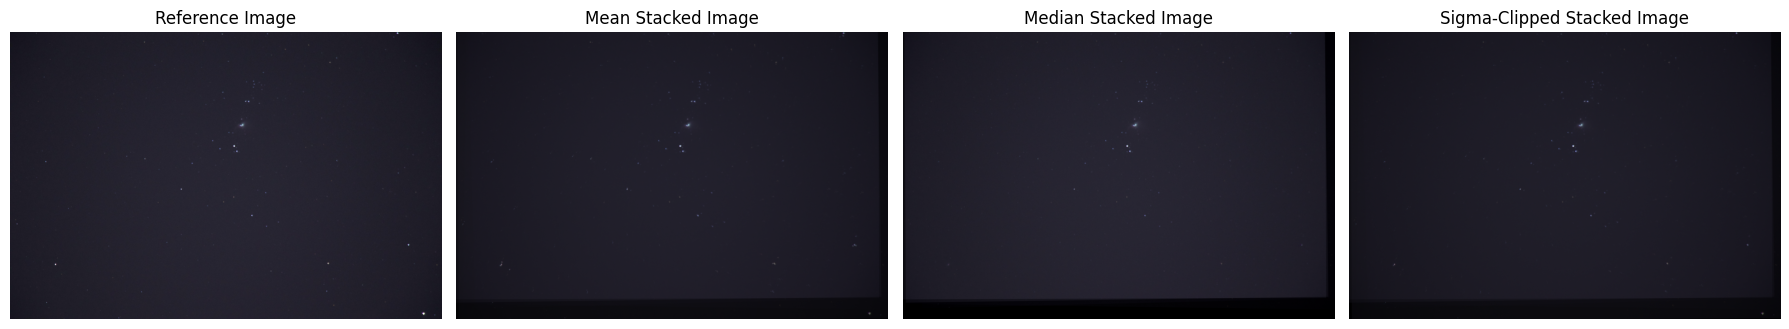

In [7]:
# Display the stacked result
fig, axes = plt.subplots(1, 4, figsize=(18, 6))

axes[0].imshow(ref_display)
axes[0].set_title("Reference Image")
axes[0].axis("off")

axes[1].imshow(mean_display)
axes[1].set_title("Mean Stacked Image")
axes[1].axis("off")

axes[2].imshow(median_display)
axes[2].set_title("Median Stacked Image")
axes[2].axis("off")

axes[3].imshow(sigma_display)
axes[3].set_title("Sigma-Clipped Stacked Image")
axes[3].axis("off")

plt.tight_layout()
plt.show()


In [8]:
# Save mean stacked result as 16-bit TIFF
output_path = os.path.join(output_dir, "mean_stacked.tiff")
imageio.imwrite(output_path, img_as_uint(mean_display))

# Save Median stacked result
median_output_path = os.path.join(output_dir, "median_stacked.tiff")
imageio.imwrite(median_output_path, img_as_uint(median_display))

# Save sigma-clipped result
sigma_output_path = os.path.join(output_dir, "sigma_clipped_stacked.tiff")
imageio.imwrite(sigma_output_path, img_as_uint(sigma_display))

In [9]:
print("Image shape:", sigma_display.shape)

# Check pixel at galaxy center
mean_display[mean_display.shape[0] // 2, mean_display.shape[1] // 2]

Image shape: (4000, 6000, 3)


array([0.1326389 , 0.12500001, 0.17430556], dtype=float32)

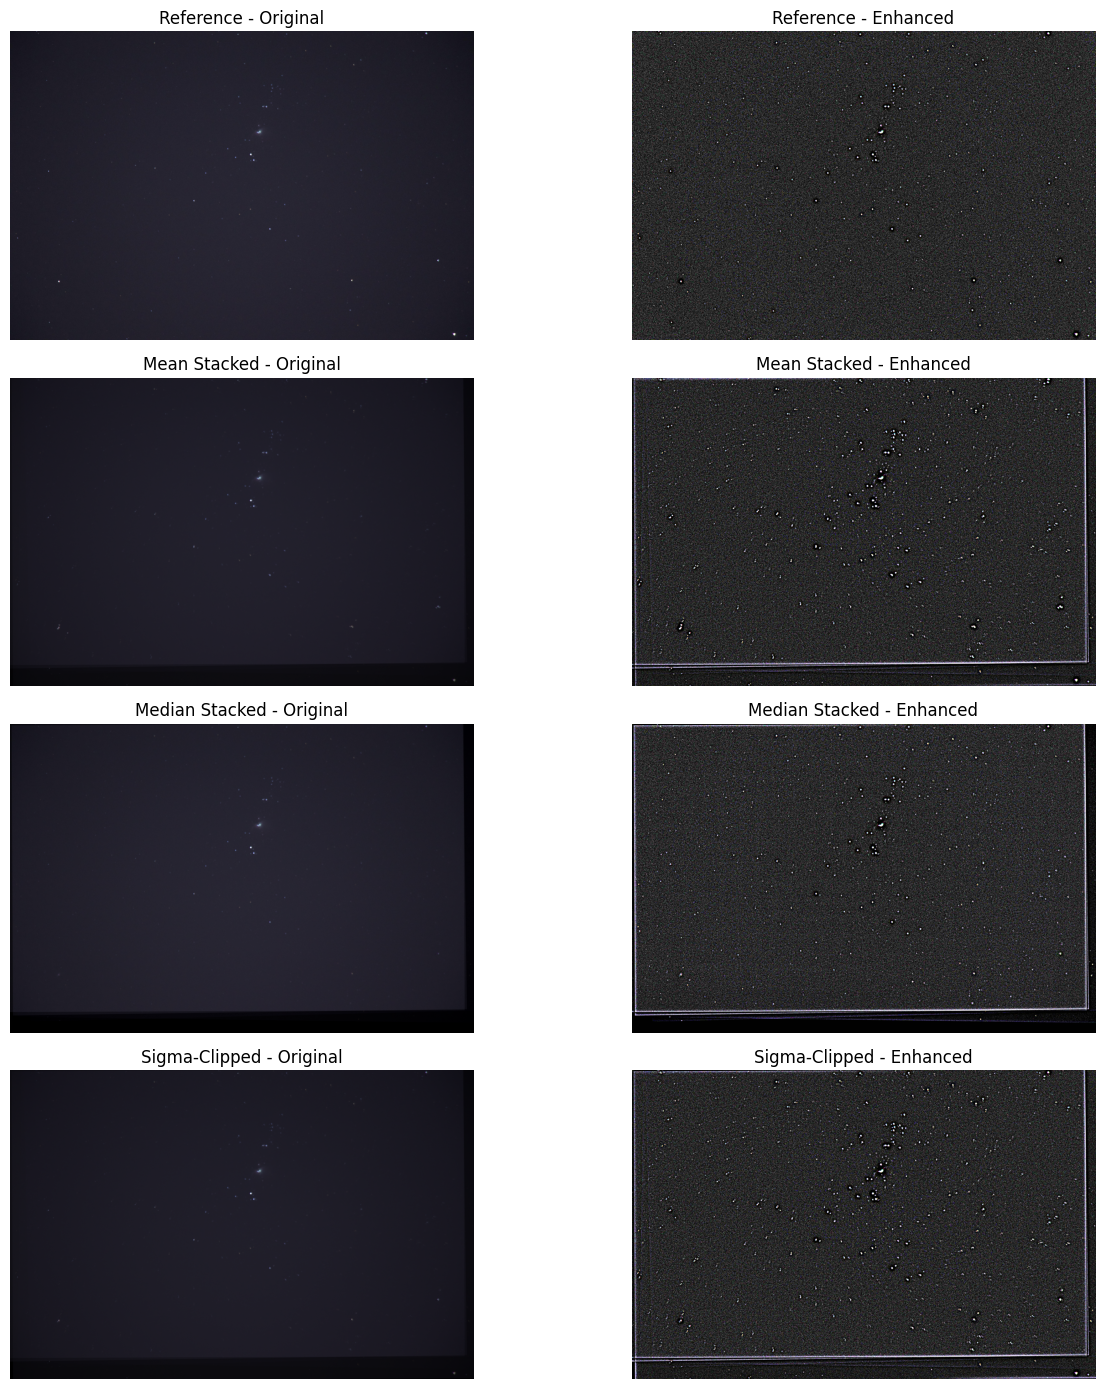

10936

In [10]:
# Advanced enhancement pipeline without color boost or star reduction
def advanced_enhance(img, gamma=1.3, clip_percent=1, blur_radius=101):
    # Step 1: Estimate and subtract sky glow (light pollution)
    blurred = cv2.GaussianBlur(img, (blur_radius, blur_radius), 0)
    img_no_background = np.clip(img - blurred, 0, 1)

    # Step 2: Strong histogram stretch
    p_low, p_high = np.percentile(img_no_background, (clip_percent, 100 - clip_percent))
    stretched = exposure.rescale_intensity(img_no_background, in_range=(p_low, p_high))

    # Step 3: Local contrast enhancement (CLAHE)
    # Convert to LAB for CLAHE on luminance
    img_8bit = (stretched * 255).astype(np.uint8)
    lab = cv2.cvtColor(img_8bit, cv2.COLOR_RGB2LAB)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    lab[:, :, 0] = clahe.apply(lab[:, :, 0])
    img_clahe = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB) / 255.0

    # Step 4: Gamma correction
    gamma_corrected = exposure.adjust_gamma(img_clahe, gamma)

    return gamma_corrected

# Apply to all 4 images
adv_ref = advanced_enhance(ref_display)
adv_mean = advanced_enhance(mean_display)
adv_median = advanced_enhance(median_display)
adv_sigma = advanced_enhance(sigma_display)

# Plot before & after for all images
titles = ["Reference", "Mean Stacked", "Median Stacked", "Sigma-Clipped"]
originals = [ref_display, mean_display, median_display, sigma_display]
enhanced = [adv_ref, adv_mean, adv_median, adv_sigma]

fig, axes = plt.subplots(len(originals), 2, figsize=(14, 14))
for i in range(len(originals)):
    axes[i][0].imshow(originals[i])
    axes[i][0].set_title(f"{titles[i]} - Original")
    axes[i][0].axis("off")

    axes[i][1].imshow(enhanced[i])
    axes[i][1].set_title(f"{titles[i]} - Enhanced")
    axes[i][1].axis("off")

plt.tight_layout()
plt.show()

del adv_ref, adv_mean, adv_median, adv_sigma
gc.collect()